## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import ollama

from tqdm import tqdm
tqdm.pandas()

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tejasmehta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_original = pd.read_csv("/Users/tejasmehta/Library/CloudStorage/OneDrive-Personal/Tejas Files/Data Science/ScrollMark/engagements.csv")

## Setup Local LLM

In [ ]:

_ = ollama.generate(
    model='gemma3:4b',
    prompt='warmup',
    keep_alive='60m'
)

## Sentiment of the Comments

In [116]:
def get_sentiment(comment):
    prompt = f"""What is the sentiment for the comment - 
    
    comment - {comment}
    
    Give the response in 1 word - Positive, Negative or Neutral."""
    
    response = ollama.generate(model="gemma3:4b", prompt=prompt, keep_alive="60m")
    return response["response"].strip()




In [ ]:
df_original["sentiment"] = df_original["comment_text"].progress_apply(get_sentiment)

## Get Flavours

In [117]:
import json, re

def get_flavours(comment: str):
    prompt = f"""
Extract the flavour/scent name mentioned in the customer comment below.
- Give the response in 1 word
- I could think of flavour/scent names like mint, vanilla
- If none are mentioned, return unknown string
- Do not include generic words like "scent" or "smell" or "balm"; only concrete flavours/scents.

Comment: {json.dumps(comment)}
"""
    try:
        resp = ollama.generate(model="gemma3:4b", prompt=prompt, keep_alive="30m")
        text = resp["response"].strip()

        
        return text
    except Exception:
        return ["None"]


In [ ]:
df_original["flavours"] = df_original["comment_text"].progress_apply(get_flavours)

## Get Themes

In [118]:
_ = ollama.generate(
    model='gemma3:4b',
    prompt='warmup',
    keep_alive='120m'
)

def get_themes(comment):
    prompt = f"""
    
    You are analyzing customer comments for Tree Hut products.  
Your task is to classify each comment into ONE of the following themes.  

### THEMES & DEFINITIONS  
1. **Fragrance & Scent Preferences** – Mentions of liking, disliking, or requesting specific scents (e.g., “pink champagne”, “vanilla”, “trash scent”).  
2. **Product Availability & Purchase** – Questions about where to buy, stock-outs, store availability, or country-level availability.  
3. **Product Performance & Usage** – Comments about how the product works on skin (hydration, exfoliation, irritation, greasy, effective/ineffective).  
4. **Packaging & Design** – Comments on size, jar/tube, leakage, design, lid, or branding.  
5. **Price & Value** – Mentions of price, affordability, value for money, or comparisons to competitors.  
6. **Emotional / Lifestyle Fit** – Expressions of love, obsession, gifting, or linking scent to lifestyle/experiences (vacation, beach, holidays).  
7. **Product Requests & Suggestions** – Requests for new products, discontinued scents to return, or suggestions for sets (scrub + lotion, etc.).  
8. **Customer Service & Brand Perception** – Praise/complaints about Tree Hut as a brand, customer service, or shipping issues.  
9. **Promotions & Influencer Mentions** – Mentions of social media (TikTok, Instagram), influencers, promo codes, or trends.  
10. **Miscellaneous / Noise** – Off-topic, spam, or irrelevant comments (e.g., only emojis, “what’s with the eyes”).  

### INSTRUCTIONS  
- Read the comment carefully.  
- Assign **exactly one** theme from the list above.  
- If multiple themes apply, pick the **best primary theme**.  
- If unclear, default to **Miscellaneous / Noise**.  

### OUTPUT FORMAT  
Respond in valid STRING ONLY, no extra text:  

    
    Here is the comment - {comment}
    
    """
    
    response = ollama.generate(model="gemma3:4b", prompt=prompt, keep_alive="120m")
    return response["response"].strip()


In [ ]:
df_sample = df[1:1500]
df_sample["themes"] = df_sample["clean_comment"].progress_apply(get_themes)

## Data Loading

Note: The above Local LLM calls were done parallely in separate jupyter notebook to save time. In the below code snippets, I have just loaded the files I collected after the LLM response and merged them.

In [3]:
df_sentiment = pd.read_csv("/Users/tejasmehta/Library/CloudStorage/OneDrive-Personal/Tejas Files/Data Science/ScrollMark/engagement_sentiments.csv")
df_sentiment = df_sentiment[["timestamp","media_id","media_caption","comment_text","sentiment"]]

In [4]:
df_flavours = pd.read_csv("/Users/tejasmehta/Library/CloudStorage/OneDrive-Personal/Tejas Files/Data Science/ScrollMark/engagements_flavours.csv")

In [5]:
df_themes = pd.read_csv("/Users/tejasmehta/Library/CloudStorage/OneDrive-Personal/Tejas Files/Data Science/ScrollMark/engagements_themes.csv")

df_themes = df_themes[["timestamp","media_id","media_caption","comment_text","themes"]]

In [7]:
valid_themes = [
    "Fragrance & Scent Preferences",
    "Product Availability & Purchase",
    "Product Performance & Usage",
    "Packaging & Design",
    "Price & Value",
    "Emotional / Lifestyle Fit",
    "Product Requests & Suggestions",
    "Customer Service & Brand Perception",
    "Promotions & Influencer Mentions",
    "Miscellaneous / Noise"
]

# Filter df to only rows where "themes" is in the valid list
df_themes = df_themes[df_themes["themes"].isin(valid_themes)].copy()

In [8]:
df_themes

,timestamp,media_id,media_caption,comment_text,themes
0,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Fragrance & Scent Preferences
1,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Emotional / Lifestyle Fit
2,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Product Availability & Purchase
3,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Emotional / Lifestyle Fit
4,2025-03-01 01:20:26.410000+00:00,1092654676238221,My go-to for waking up my skin! 🍊🫧 Click the l...,Anndy Marin,Miscellaneous / Noise
...,...,...,...,...,...
1470,2025-03-21 15:20:46.554000+00:00,18036343751267796,APPLICATIONS ARE NOW CLOSED! 🚨 \nThank you to ...,TREEHUT PR,Miscellaneous / Noise
1479,2025-03-21 15:19:02.091000+00:00,18036343751267796,APPLICATIONS ARE NOW CLOSED! 🚨 \nThank you to ...,TREEHUT PR ✨,Miscellaneous / Noise
1480,2025-03-21 15:21:12.301000+00:00,18036343751267796,APPLICATIONS ARE NOW CLOSED! 🚨 \nThank you to ...,TREEHUT PR☀️💕🌻,Miscellaneous / Noise
1489,2025-03-21 15:28:43.173000+00:00,18036343751267796,APPLICATIONS ARE NOW CLOSED! 🚨 \nThank you to ...,TREEHUT PR,Miscellaneous / Noise


In [9]:
df = pd.merge(df_original, df_sentiment, on=["timestamp","media_id","media_caption","comment_text"], how="left")

In [10]:
df

,timestamp,media_id,media_caption,comment_text,sentiment
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Positive
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Positive
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Positive
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Positive
...,...,...,...,...,...
17836,2025-04-02 18:27:20.065000+00:00,1125861369584218,that's that me espresso,Anthony Baggio I want,Neutral
17837,2025-04-02 18:28:41.488000+00:00,18076572166794234,Let us know what your Spring Vibe is going to ...,A1!😍,Positive
17838,2025-04-02 18:31:56.153000+00:00,1125861369584218,that's that me espresso,Cydney Shue for you babes,Positive
17839,2025-04-02 18:29:08.782000+00:00,1125861369584218,that's that me espresso,Bryanna Crable omg I need 😂😂,Positive


In [11]:
df = pd.merge(df, df_flavours, on=["timestamp","media_id","media_caption","comment_text"], how="left")

In [12]:
#df

In [13]:
df = pd.merge(df, df_themes, on=["timestamp","media_id","media_caption","comment_text"], how="left")

In [14]:
df

,timestamp,media_id,media_caption,comment_text,sentiment,flavours,themes
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,Unknown,NaN
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Positive,Unknown,Fragrance & Scent Preferences
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Positive,unknown,Emotional / Lifestyle Fit
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Positive,Unknown,Product Availability & Purchase
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Positive,Vanilla,Emotional / Lifestyle Fit
...,...,...,...,...,...,...,...
17836,2025-04-02 18:27:20.065000+00:00,1125861369584218,that's that me espresso,Anthony Baggio I want,Neutral,Unknown,NaN
17837,2025-04-02 18:28:41.488000+00:00,18076572166794234,Let us know what your Spring Vibe is going to ...,A1!😍,Positive,Unknown,NaN
17838,2025-04-02 18:31:56.153000+00:00,1125861369584218,that's that me espresso,Cydney Shue for you babes,Positive,Unknown,NaN
17839,2025-04-02 18:29:08.782000+00:00,1125861369584218,that's that me espresso,Bryanna Crable omg I need 😂😂,Positive,Unknown,NaN


## Data Cleaning

In [15]:
# --- Compile reusable regexes ---
URL_RE = re.compile(
    r"""(?xi)
    \b(
        (?:https?://|www\.)\S+        # http(s) or www links
        |                             # or bare domains like foo.com/path
        [A-Za-z0-9.-]+\.[A-Za-z]{2,}(?:/\S*)?
    )
    """
)
MENTION_RE = re.compile(r"(?<!\w)@[A-Za-z0-9_\.]+")          # @mentions
HASHTAG_RE  = re.compile(r"(?<!\w)#([A-Za-z0-9_]+)")         # capture tag text
EMAIL_RE    = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")      # emails

# Common promo code patterns: "use code SAVE20", "promo CODE: ABC123", "coupon: XYZ"
PROMO_PHRASE_RE = re.compile(
    r"""(?xi)
    \b(?:use\s+code|promo\s*code|coupon\s*code|coupon|code)\s*[:\-]?\s*
    ([A-Z0-9\-]{3,})\b
    """
)
# Standalone loud-looking codes (e.g., SAVE20, ABC123) not part of normal words
PROMO_LONE_RE = re.compile(r"\b[A-Z0-9]{4,12}\b")

# Emoji & pictograph ranges (covers most modern emoji)
EMOJI_RE = re.compile(
    "["                                   # start char class
    "\U0001F600-\U0001F64F"               # emoticons
    "\U0001F300-\U0001F5FF"               # symbols & pictographs
    "\U0001F680-\U0001F6FF"               # transport & map
    "\U0001F700-\U0001F77F"               # alchemical
    "\U0001F780-\U0001F7FF"               # geometric ext
    "\U0001F800-\U0001F8FF"               # supplemental arrows C
    "\U0001F900-\U0001F9FF"               # supplemental symbols & pictographs
    "\U0001FA00-\U0001FAFF"               # symbols & pictographs ext-A
    "\U00002700-\U000027BF"               # dingbats
    "\U00002600-\U000026FF"               # misc symbols
    "\U00002B00-\U00002BFF"               # arrows etc
    "\U00002300-\U000023FF"               # misc technical
    "\U0000200D"                          # zero width joiner
    "\U0000FE0F"                          # variation selector-16
    "]",
    flags=re.UNICODE
)

# Collapse loooong character runs ("soooo" -> "soo")
ELONG_RE = re.compile(r"(.)\1{2,}")

# Keep letters/numbers/space; turn the rest into spaces
NON_WORD_SPACE_RE = re.compile(r"[^a-zA-Z0-9\s]+")

def clean_comment(text: str) -> str:
    if not isinstance(text, str):
        return ""
    s = text

    # 1) Remove URLs & emails
    s = URL_RE.sub(" ", s)
    s = EMAIL_RE.sub(" ", s)

    # 2) Remove @mentions entirely
    s = MENTION_RE.sub(" ", s)

    # 3) Strip emojis/pictographs
    s = EMOJI_RE.sub(" ", s)

    # 4) Remove promo codes:
    #   a) phrases like "use code SAVE20"
    s = PROMO_PHRASE_RE.sub(" ", s)
    #   b) standalone all-caps/numeric codes (keep if part of word? here we drop)
    s = PROMO_LONE_RE.sub(lambda m: " " if not m.group(0).isalpha() else " ", s)

    # 5) Hashtags: keep the word, drop the '#'
    s = HASHTAG_RE.sub(r"\1", s)

    # 6) Normalize punctuation -> space, then collapse whitespace
    s = NON_WORD_SPACE_RE.sub(" ", s)

    # 7) Optional: collapse elongated runs (soooo -> soo)
    s = ELONG_RE.sub(r"\1\1", s)

    # 8) Lowercase & whitespace tidy
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()

    return s


In [16]:
# Assuming df['comment_text'] exists
df["clean_comment"] = df["comment_text"].apply(clean_comment)
df[["comment_text", "clean_comment"]].head(10)

,comment_text,clean_comment
0,I bet this is good,i bet this is good
1,i know this smells so good,i know this smells so good
2,Love it,love it
3,Please carry these in Canada! I miss them so m...,please carry these in canada i miss them so much
4,I love it ..✌️,i love it
5,Anndy Marin,anndy marin
6,Shaheena Juliet Castellano Flavors?🧐\nI know y...,shaheena juliet castellano flavors i know you ...
7,'@brittany_lollar,
8,Emerald,emerald
9,'@kalwone,


In [17]:
# Remove rows where clean_comment is empty or only whitespace
df_non_empty = df[df["clean_comment"].notna() & (df["clean_comment"].str.strip() != "")]

# Reset index if you want a clean DataFrame
df_non_empty = df_non_empty.reset_index(drop=True)

In [18]:
df_non_empty

,timestamp,media_id,media_caption,comment_text,sentiment,flavours,themes,clean_comment
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,Unknown,NaN,i bet this is good
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Positive,Unknown,Fragrance & Scent Preferences,i know this smells so good
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Positive,unknown,Emotional / Lifestyle Fit,love it
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Positive,Unknown,Product Availability & Purchase,please carry these in canada i miss them so much
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Positive,Vanilla,Emotional / Lifestyle Fit,i love it
...,...,...,...,...,...,...,...,...
11975,2025-04-02 18:22:25.184000+00:00,1125861369584218,that's that me espresso,That looks like it feels amazing,Positive,Unknown,NaN,that looks like it feels amazing
11976,2025-04-02 18:27:20.065000+00:00,1125861369584218,that's that me espresso,Anthony Baggio I want,Neutral,Unknown,NaN,anthony baggio i want
11977,2025-04-02 18:28:41.488000+00:00,18076572166794234,Let us know what your Spring Vibe is going to ...,A1!😍,Positive,Unknown,NaN,a1
11978,2025-04-02 18:31:56.153000+00:00,1125861369584218,that's that me espresso,Cydney Shue for you babes,Positive,Unknown,NaN,cydney shue for you babes


In [19]:
valid_sentiments = ["Positive", "Negative", "Neutral"]
df_sent = df_non_empty[df_non_empty["sentiment"].isin(valid_sentiments)].reset_index(drop=True)

In [20]:
df_sent

,timestamp,media_id,media_caption,comment_text,sentiment,flavours,themes,clean_comment
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,Unknown,NaN,i bet this is good
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Positive,Unknown,Fragrance & Scent Preferences,i know this smells so good
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Positive,unknown,Emotional / Lifestyle Fit,love it
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Positive,Unknown,Product Availability & Purchase,please carry these in canada i miss them so much
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Positive,Vanilla,Emotional / Lifestyle Fit,i love it
...,...,...,...,...,...,...,...,...
11911,2025-04-02 18:22:25.184000+00:00,1125861369584218,that's that me espresso,That looks like it feels amazing,Positive,Unknown,NaN,that looks like it feels amazing
11912,2025-04-02 18:27:20.065000+00:00,1125861369584218,that's that me espresso,Anthony Baggio I want,Neutral,Unknown,NaN,anthony baggio i want
11913,2025-04-02 18:28:41.488000+00:00,18076572166794234,Let us know what your Spring Vibe is going to ...,A1!😍,Positive,Unknown,NaN,a1
11914,2025-04-02 18:31:56.153000+00:00,1125861369584218,that's that me espresso,Cydney Shue for you babes,Positive,Unknown,NaN,cydney shue for you babes


In [21]:
df_sent["flavours"] = df_sent["flavours"].replace("unknown", "Unknown")

In [22]:
df_sent["flavours"].value_counts()

flavours
Unknown             10595
Vanilla               289
Espresso              284
Moroccan              226
Rose                  123
Tangerine             116
Lotus                  97
Pineapple              64
Coco                   56
Sugar                  17
Clementine             10
COCO                    5
Colada                  5
Cococolada              3
Sugars                  3
Mint                    3
Jasmine                 3
Dreamy                  2
Sugary                  2
Sandalwood              1
Beach                   1
OrangeCreamsicle        1
COCOCOLADA              1
Pumpkin                 1
Shea                    1
Pear                    1
Dragon                  1
Banana                  1
Cherry                  1
Cinnamon                1
Orange                  1
Lampone                 1
Name: count, dtype: int64

In [26]:
df_sent["themes"].value_counts()

themes
Miscellaneous / Noise                  512
Fragrance & Scent Preferences          236
Emotional / Lifestyle Fit              208
Product Performance & Usage             96
Product Requests & Suggestions          76
Product Availability & Purchase         65
Price & Value                           15
Customer Service & Brand Perception     15
Promotions & Influencer Mentions         9
Packaging & Design                       5
Name: count, dtype: int64

## Segment of Day, Day Name and Day of Week

In [24]:
df_sent["timestamp"] = pd.to_datetime(df_sent["timestamp"], errors="coerce")

# Day of month (1–31)
df_sent['day'] = df_sent['timestamp'].dt.day

# If you also want day of week (e.g., Monday, Tuesday)
df_sent['day_name'] = df_sent['timestamp'].dt.day_name()

# If you want numeric day of week (0=Monday, 6=Sunday)
df_sent['day_of_week'] = df_sent['timestamp'].dt.dayofweek

In [25]:
df_sent

,timestamp,media_id,media_caption,comment_text,sentiment,flavours,themes,clean_comment,day,day_name,day_of_week
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,Unknown,NaN,i bet this is good,1,Saturday,5
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Positive,Unknown,Fragrance & Scent Preferences,i know this smells so good,1,Saturday,5
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Positive,Unknown,Emotional / Lifestyle Fit,love it,1,Saturday,5
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Positive,Unknown,Product Availability & Purchase,please carry these in canada i miss them so much,1,Saturday,5
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Positive,Vanilla,Emotional / Lifestyle Fit,i love it,1,Saturday,5
...,...,...,...,...,...,...,...,...,...,...,...
11911,2025-04-02 18:22:25.184000+00:00,1125861369584218,that's that me espresso,That looks like it feels amazing,Positive,Unknown,NaN,that looks like it feels amazing,2,Wednesday,2
11912,2025-04-02 18:27:20.065000+00:00,1125861369584218,that's that me espresso,Anthony Baggio I want,Neutral,Unknown,NaN,anthony baggio i want,2,Wednesday,2
11913,2025-04-02 18:28:41.488000+00:00,18076572166794234,Let us know what your Spring Vibe is going to ...,A1!😍,Positive,Unknown,NaN,a1,2,Wednesday,2
11914,2025-04-02 18:31:56.153000+00:00,1125861369584218,that's that me espresso,Cydney Shue for you babes,Positive,Unknown,NaN,cydney shue for you babes,2,Wednesday,2


## Get Country Name through NER

In [27]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

import re
import spacy
nlp = spacy.load("en_core_web_sm")

# Minimal list; extend if you need more
COUNTRIES_MIN = {
    "United States","Canada","Mexico","United Kingdom","France","Germany","Italy","Spain",
    "Portugal","Netherlands","Belgium","Switzerland","Austria","Ireland","Denmark","Sweden",
    "Norway","Finland","Poland","Czechia","Greece","Turkey","Russia","Ukraine",
    "Australia","New Zealand","Japan","China","India","Singapore","South Africa",
    "Brazil","Argentina","Chile","Colombia","Peru","Venezuela","United Arab Emirates",
    "Saudi Arabia","Egypt","Israel","Indonesia","Malaysia","Philippines","Thailand",
    "Vietnam","Korea, Republic of","Korea, Democratic People's Republic of"
}

ALIASES_MIN = {
    "usa": "United States",
    "us": "United States",
    "u.s.": "United States",
    "u.s.a.": "United States",
    "uk": "United Kingdom",
    "u.k.": "United Kingdom",
    "england": "United Kingdom",
    "scotland": "United Kingdom",
    "wales": "United Kingdom",
    "south korea": "Korea, Republic of",
    "north korea": "Korea, Democratic People's Republic of",
    "russia": "Russia",
    "czech republic": "Czechia",
    "uae": "United Arab Emirates",
    "u.a.e.": "United Arab Emirates",
}

def normalize_country_min(text):
    s = re.sub(r"\s+", " ", text.strip().lower())
    s = re.sub(r"[^\w\s\.]", "", s)
    if s in ALIASES_MIN:
        return ALIASES_MIN[s]
    # exact match against our set
    for name in COUNTRIES_MIN:
        if s == name.lower():
            return name
    s2 = s.replace(".", "")
    if s2 in ALIASES_MIN:
        return ALIASES_MIN[s2]
    return None

def extract_countries_spacy_min(text):
    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    cand = []
    for ent in doc.ents:
        if ent.label_ in ("GPE", "LOC"):
            norm = normalize_country_min(ent.text)
            if norm:
                cand.append(norm)
    # uniquify preserving order
    seen, out = set(), []
    for c in cand:
        if c not in seen:
            seen.add(c); out.append(c)
    return out

df_sent["countries_mentioned"] = df["clean_comment"].progress_apply(extract_countries_spacy_min)

100%|████████████████████████████████████| 17841/17841 [00:26<00:00, 669.37it/s]


In [30]:
#df_sent

In [31]:
df_sent["country"] = df_sent["countries_mentioned"].progress_apply(lambda xs: xs[0] if xs else "Unknown")

100%|█████████████████████████████████| 11916/11916 [00:00<00:00, 664875.10it/s]


In [32]:
df_sent

,timestamp,media_id,media_caption,comment_text,sentiment,flavours,themes,clean_comment,day,day_name,day_of_week,countries_mentioned,country
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,Unknown,NaN,i bet this is good,1,Saturday,5,[],Unknown
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Positive,Unknown,Fragrance & Scent Preferences,i know this smells so good,1,Saturday,5,[],Unknown
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Positive,Unknown,Emotional / Lifestyle Fit,love it,1,Saturday,5,[],Unknown
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Positive,Unknown,Product Availability & Purchase,please carry these in canada i miss them so much,1,Saturday,5,[Canada],Canada
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Positive,Vanilla,Emotional / Lifestyle Fit,i love it,1,Saturday,5,[],Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11911,2025-04-02 18:22:25.184000+00:00,1125861369584218,that's that me espresso,That looks like it feels amazing,Positive,Unknown,NaN,that looks like it feels amazing,2,Wednesday,2,[],Unknown
11912,2025-04-02 18:27:20.065000+00:00,1125861369584218,that's that me espresso,Anthony Baggio I want,Neutral,Unknown,NaN,anthony baggio i want,2,Wednesday,2,[],Unknown
11913,2025-04-02 18:28:41.488000+00:00,18076572166794234,Let us know what your Spring Vibe is going to ...,A1!😍,Positive,Unknown,NaN,a1,2,Wednesday,2,[],Unknown
11914,2025-04-02 18:31:56.153000+00:00,1125861369584218,that's that me espresso,Cydney Shue for you babes,Positive,Unknown,NaN,cydney shue for you babes,2,Wednesday,2,[],Unknown


In [33]:
df_sent["country"].value_counts()

country
Unknown           11892
Canada               10
United Kingdom        9
Australia             1
Brazil                1
Spain                 1
Netherlands           1
United States         1
Name: count, dtype: int64

## Df

In [34]:
df = df_sent.copy()

## Overall Sentiment

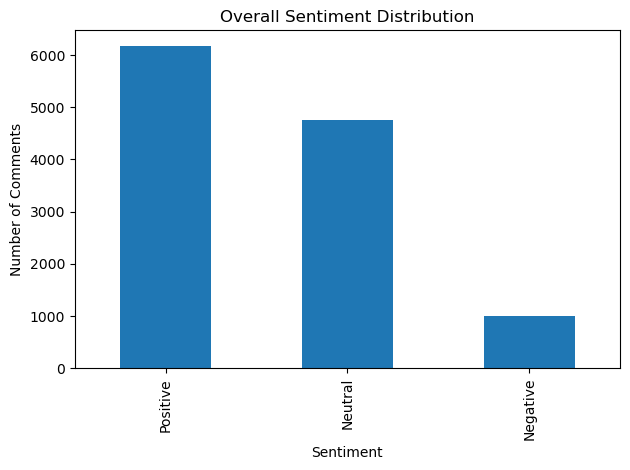

In [35]:
#Overall Sentiment of Comments

sent_counts = df["sentiment"].value_counts().reindex(["Positive","Neutral", "Negative"]).fillna(0)
plt.figure()
sent_counts.plot(kind="bar")
plt.title("Overall Sentiment Distribution")
plt.ylabel("Number of Comments")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()

## Daily Comment Volume

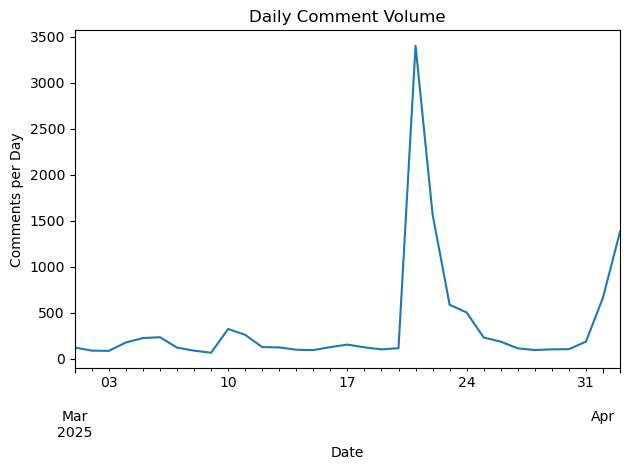

In [36]:
daily_vol = df.set_index("timestamp").resample("D")["comment_text"].count()
plt.figure()
daily_vol.plot()
plt.title("Daily Comment Volume")
plt.ylabel("Comments per Day")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

## Sentiment over time — daily % positive & % negative (two lines)

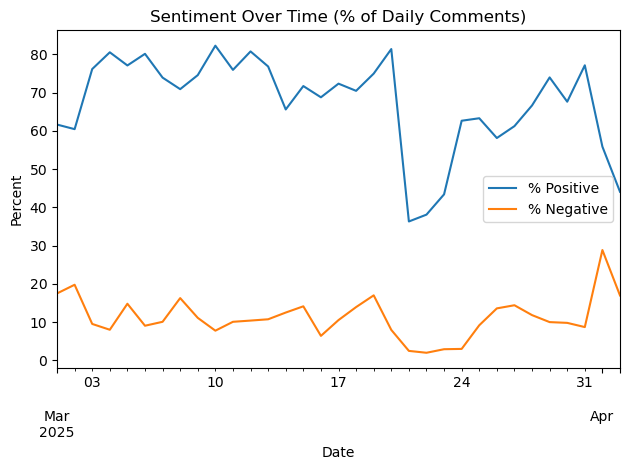

In [37]:


daily_sent = (df
              .set_index("timestamp")
              .assign(is_pos=lambda x: (x["sentiment"]=="Positive").astype(int),
                      is_neg=lambda x: (x["sentiment"]=="Negative").astype(int))
              .resample("D")
              .agg(total=("comment_text","count"),
                   pos=("is_pos","mean"),
                   neg=("is_neg","mean"))
             )
daily_sent["pos_pct"] = (daily_sent["pos"]*100).round(2)
daily_sent["neg_pct"] = (daily_sent["neg"]*100).round(2)

plt.figure()
daily_sent["pos_pct"].plot(label="% Positive")
daily_sent["neg_pct"].plot(label="% Negative")
plt.legend()
plt.title("Sentiment Over Time (% of Daily Comments)")
plt.ylabel("Percent")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


## Top flavours by mentions (bar)

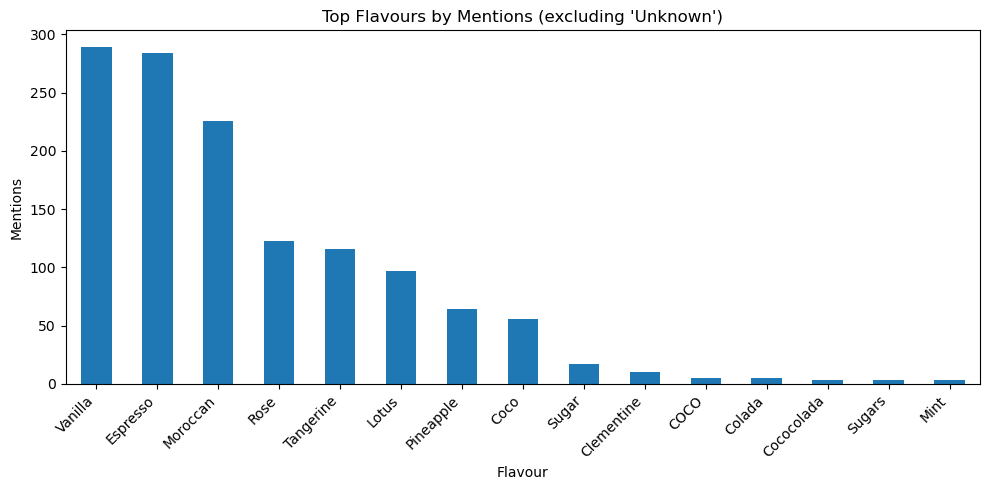

In [39]:
# Exclude "Unknown" before counting
flv_counts = (
    df.loc[df["flavours"] != "Unknown", "flavours"]
      .value_counts()
      .head(15)
)

plt.figure(figsize=(10,5))
flv_counts.plot(kind="bar")
plt.title("Top Flavours by Mentions (excluding 'Unknown' Flavours)")
plt.ylabel("Mentions")
plt.xlabel("Flavour")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Sentiment by flavour (stacked bars for top N flavours, excluding Unknown)

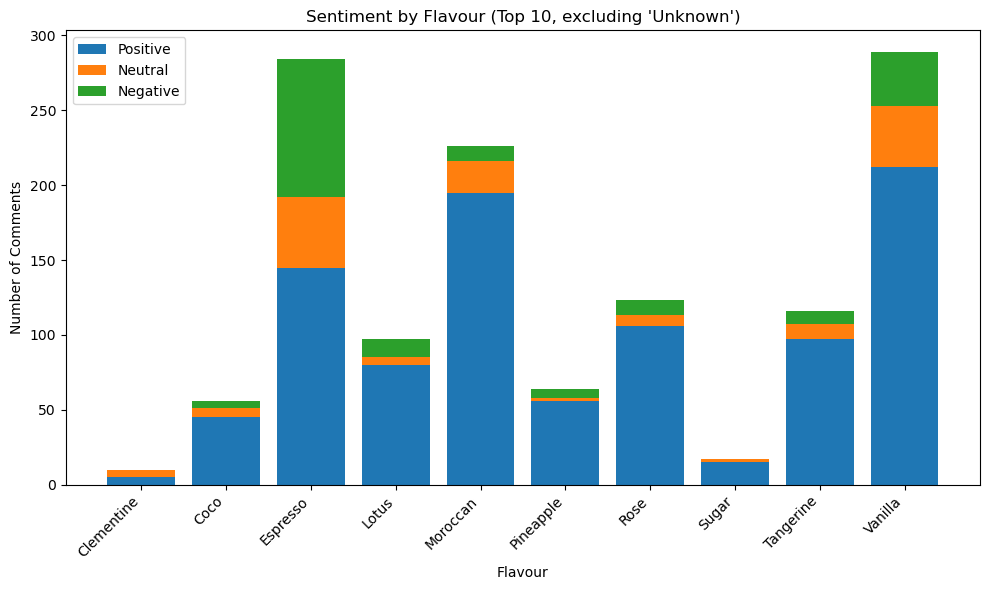

In [41]:

top_n = 10
top_flvs = (
    df.loc[df["flavours"] != "Unknown", "flavours"]
      .value_counts()
      .head(top_n)
      .index.tolist()
)

tmp = (df[df["flavours"].isin(top_flvs)]
       .groupby(["flavours","sentiment"])
       .size()
       .unstack(fill_value=0)
       .reindex(columns=["Positive","Neutral","Negative"], fill_value=0)
      )

plt.figure(figsize=(10,6))
bottom = None
for col in tmp.columns:
    if bottom is None:
        bottom = tmp[col].values
        plt.bar(tmp.index.astype(str), tmp[col].values, label=col)
    else:
        plt.bar(tmp.index.astype(str), tmp[col].values, bottom=bottom, label=col)
        bottom = bottom + tmp[col].values

plt.legend()
plt.title("Sentiment by Flavour (Top 10, excluding 'Unknown')")
plt.ylabel("Number of Comments")
plt.xlabel("Flavour")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Positivity % by flavour (bar) — good for ranking favourites

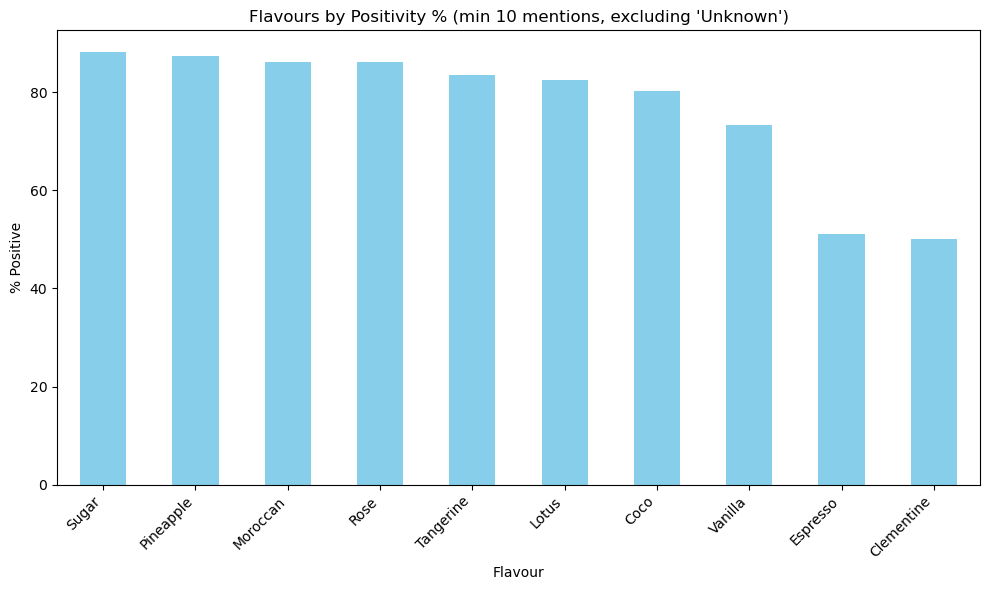

In [43]:
# Exclude "Unknown" flavour
flv_sent = (df[df["flavours"] != "Unknown"]
            .groupby(["flavours","sentiment"])
            .size()
            .unstack(fill_value=0)
           )

flv_sent["total"] = flv_sent.sum(axis=1)
flv_sent["pos_pct"] = (flv_sent.get("Positive",0) / flv_sent["total"] * 100)

top_pos = (flv_sent[flv_sent["total"] >= 10]  # filter for some support
           .sort_values("pos_pct", ascending=False)
           .head(15))

plt.figure(figsize=(10,6))
top_pos["pos_pct"].plot(kind="bar", color="skyblue")
plt.title("Flavours by Positivity % (min 10 mentions, excluding 'Unknown')")
plt.ylabel("% Positive")
plt.xlabel("Flavour")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Negativity % by flavour (bar) — good for ranking favourites

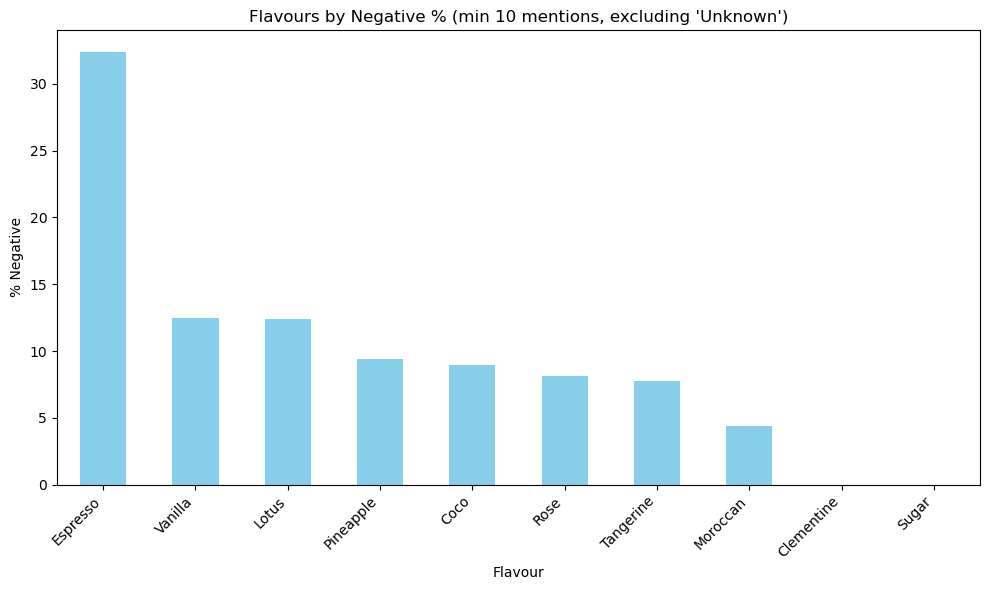

In [44]:
# Exclude "Unknown" flavour
flv_sent = (df[df["flavours"] != "Unknown"]
            .groupby(["flavours","sentiment"])
            .size()
            .unstack(fill_value=0)
           )

flv_sent["total"] = flv_sent.sum(axis=1)
flv_sent["pos_pct"] = (flv_sent.get("Negative",0) / flv_sent["total"] * 100)

top_pos = (flv_sent[flv_sent["total"] >= 10]  # filter for some support
           .sort_values("pos_pct", ascending=False)
           .head(15))

plt.figure(figsize=(10,6))
top_pos["pos_pct"].plot(kind="bar", color="skyblue")
plt.title("Flavours by Negative % (min 10 mentions, excluding 'Unknown')")
plt.ylabel("% Negative")
plt.xlabel("Flavour")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Complaint spike tracking (keywords) — daily count (line)

/var/folders/h9/np5pq1tx3cx0jhx8jnff_ffh0000gn/T/ipykernel_3111/3553007899.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_comp["is_complaint"] = df["clean_comment"].str.contains(complaint_pat, regex=True)


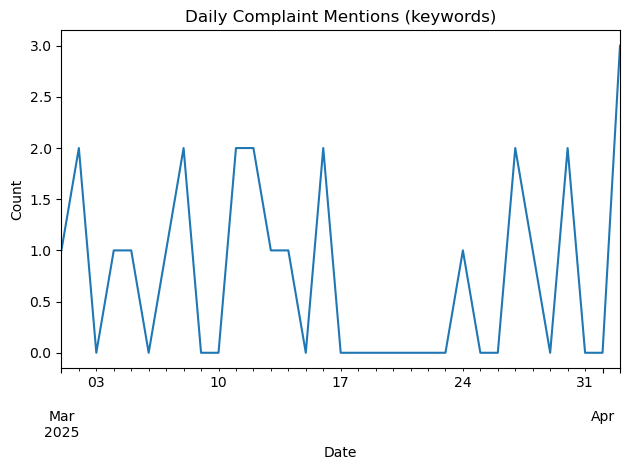

In [46]:


complaint_pat = r'\b(leak|leaked|melt|melted|cap|lid|seal|broken|broke|rash|allergic|burn|itch|greasy|sticky)\b'
df_comp = df.copy()
df_comp["is_complaint"] = df["clean_comment"].str.contains(complaint_pat, regex=True)

complaints_daily = (df_comp
                    .set_index("timestamp")
                    .resample("D")["is_complaint"]
                    .sum())

plt.figure()
complaints_daily.plot()
plt.title("Daily Complaint Mentions (keywords)")
plt.ylabel("Count")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [50]:
#df

## Positive vs Negative Sentiments Across Days

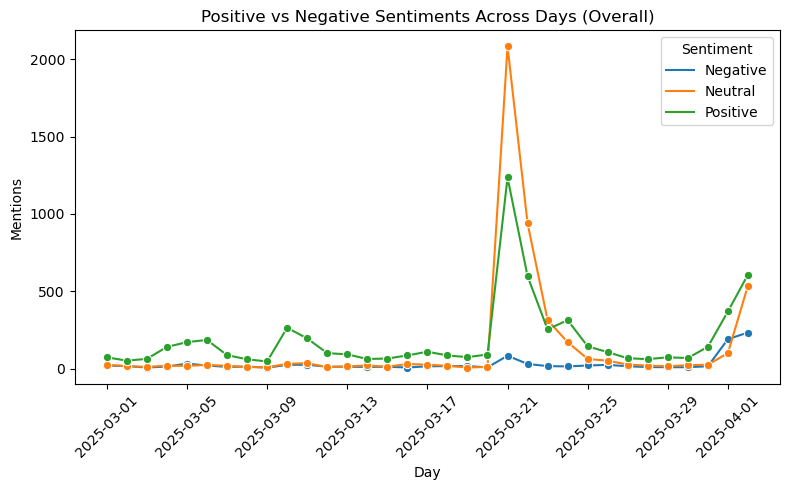

In [51]:
# Aggregate counts
sent_trends = (
    df.groupby(["day", "sentiment"])
      .size()
      .reset_index(name="count")
)

# Convert month to datetime for plotting
sent_trends["day_dt"] = pd.to_datetime(sent_trends["day"])
sent_trends = sent_trends.sort_values("day_dt")

# Plot overall trend
plt.figure(figsize=(8,5))
sns.lineplot(
    data=sent_trends, 
    x="day_dt", 
    y="count", 
    hue="sentiment", 
    marker="o"
)
plt.title("Positive vs Negative Sentiments Across Days (Overall)")
plt.xlabel("Day")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


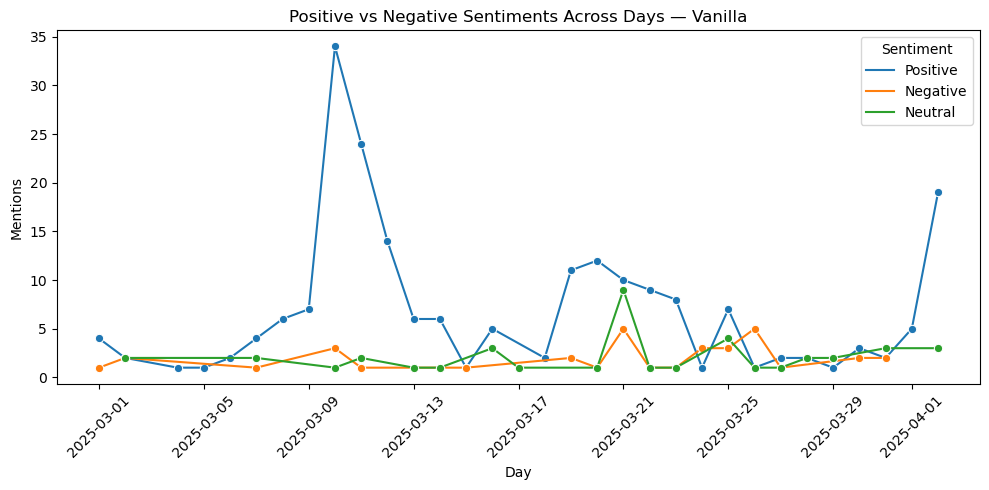

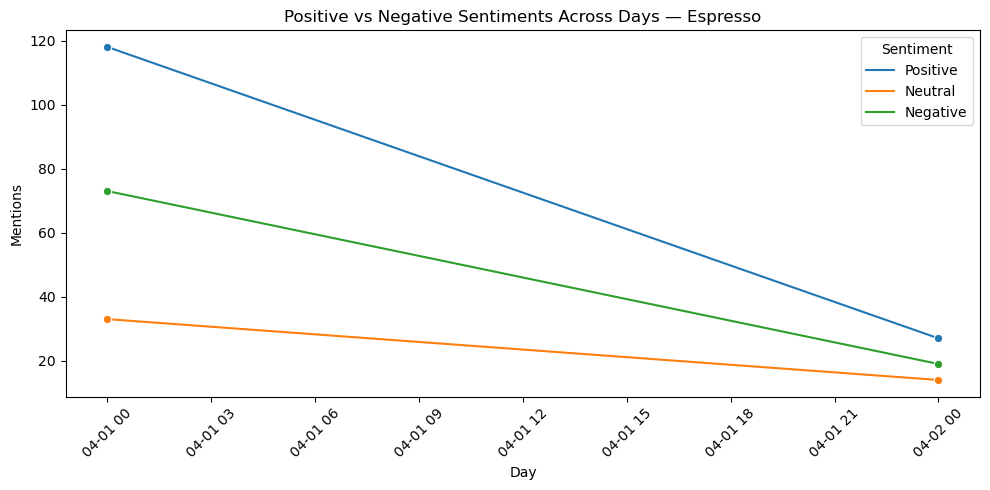

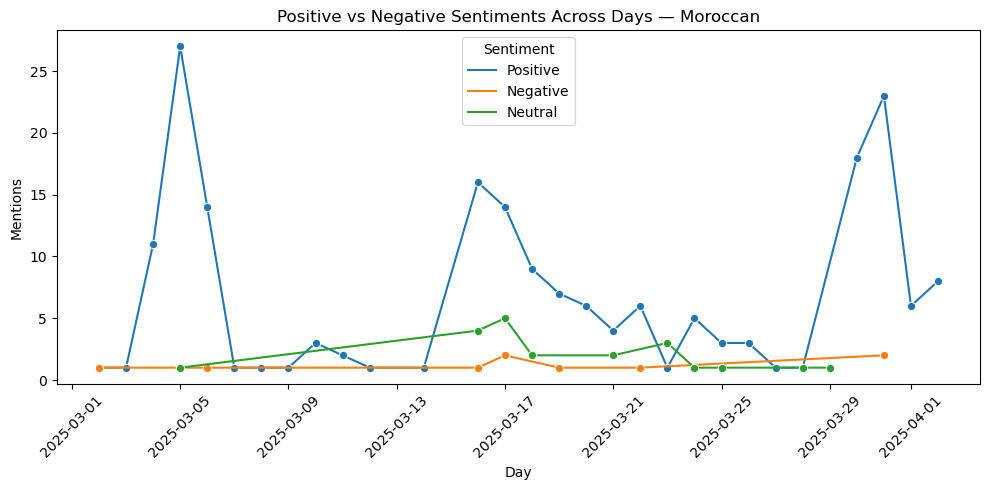

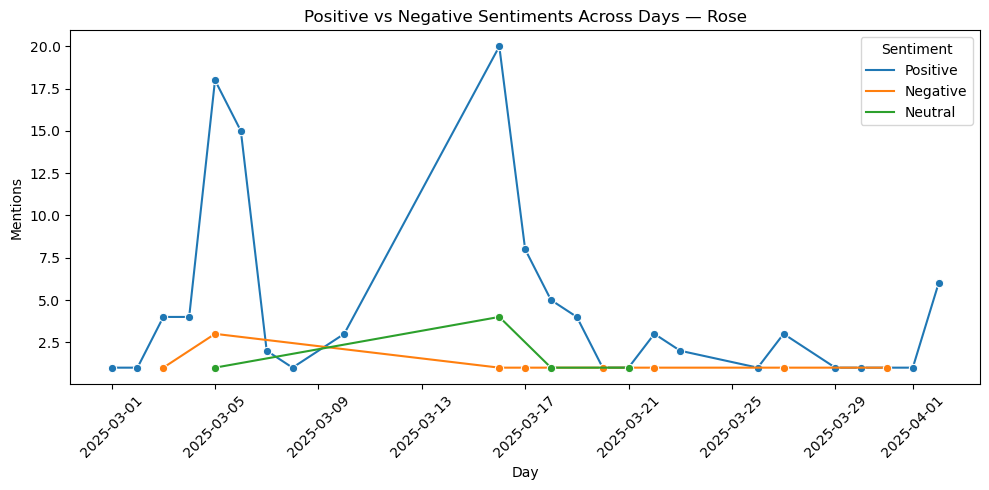

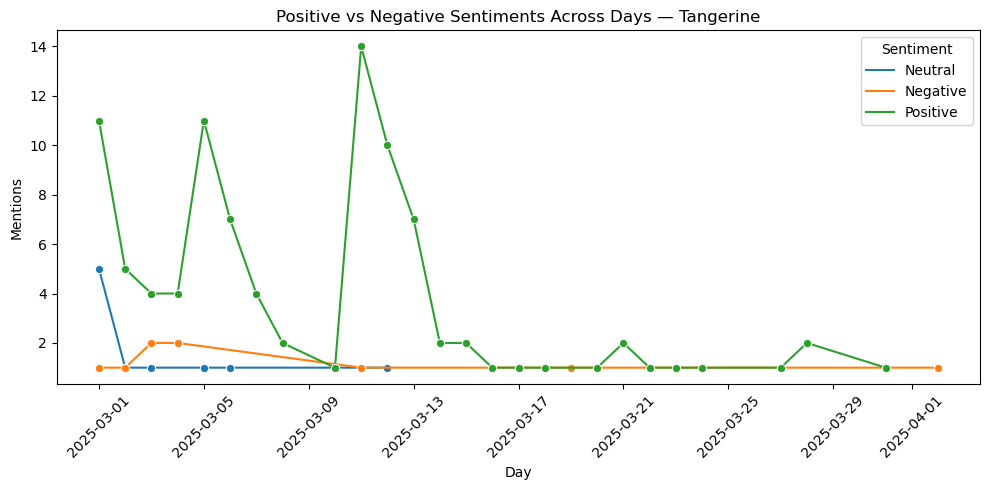

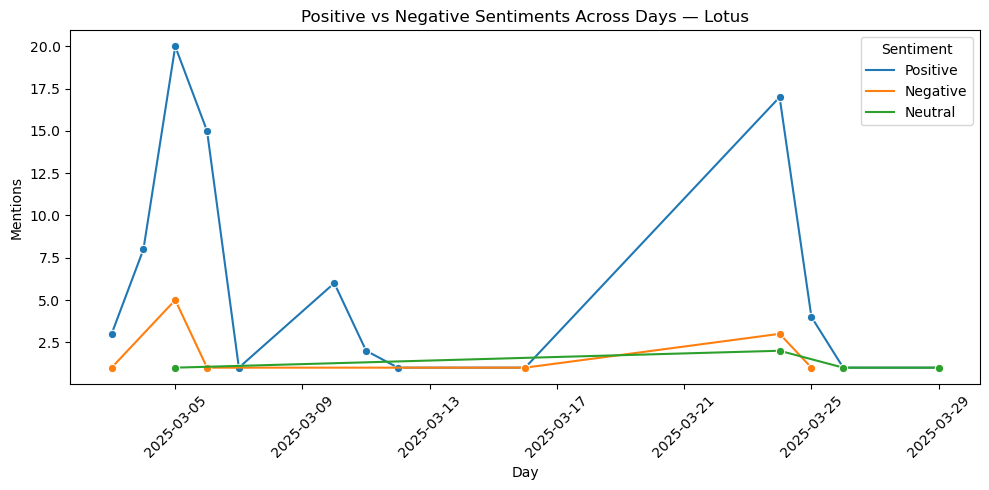

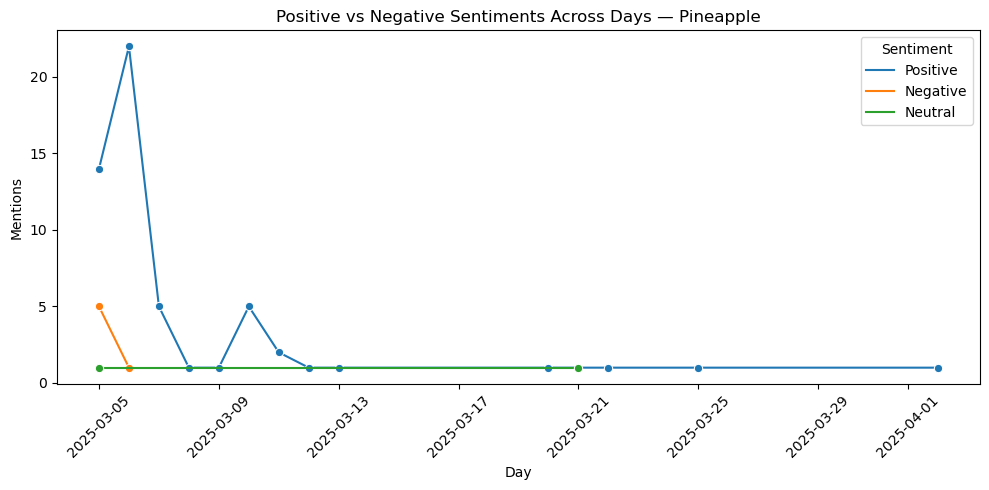

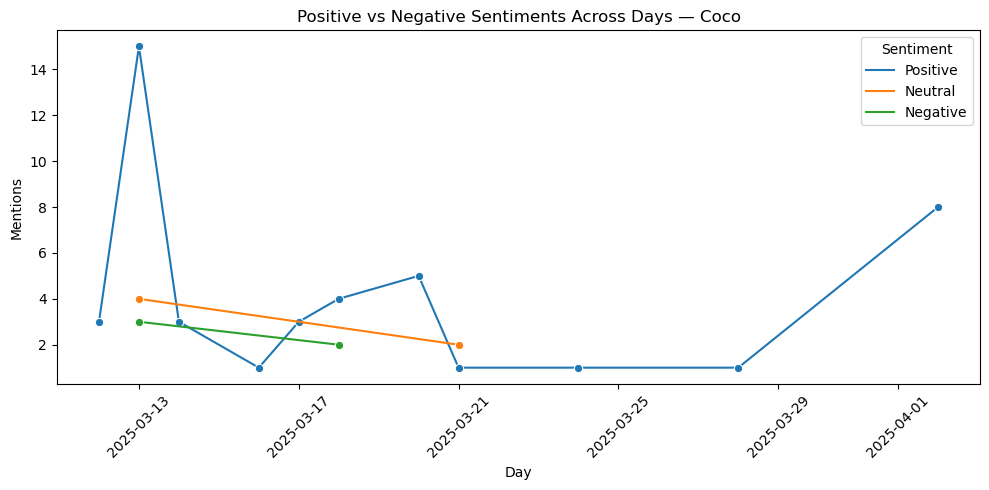

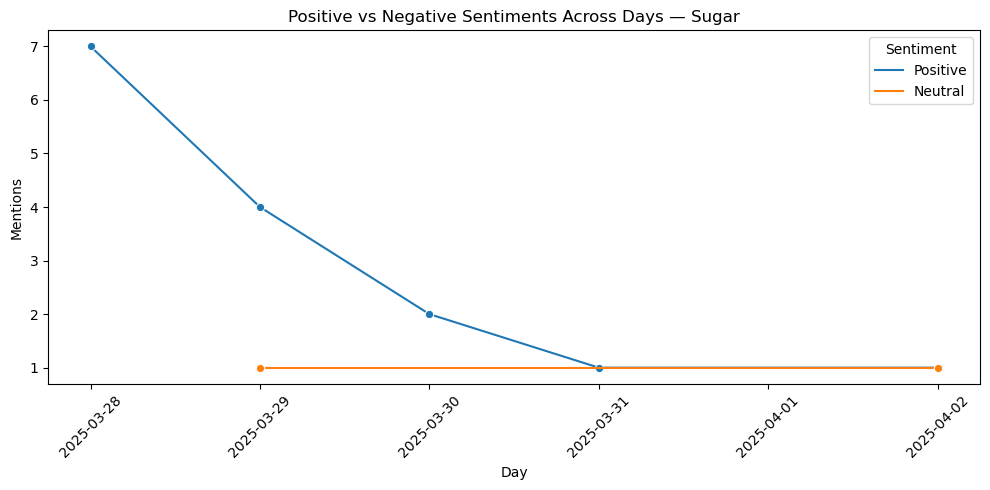

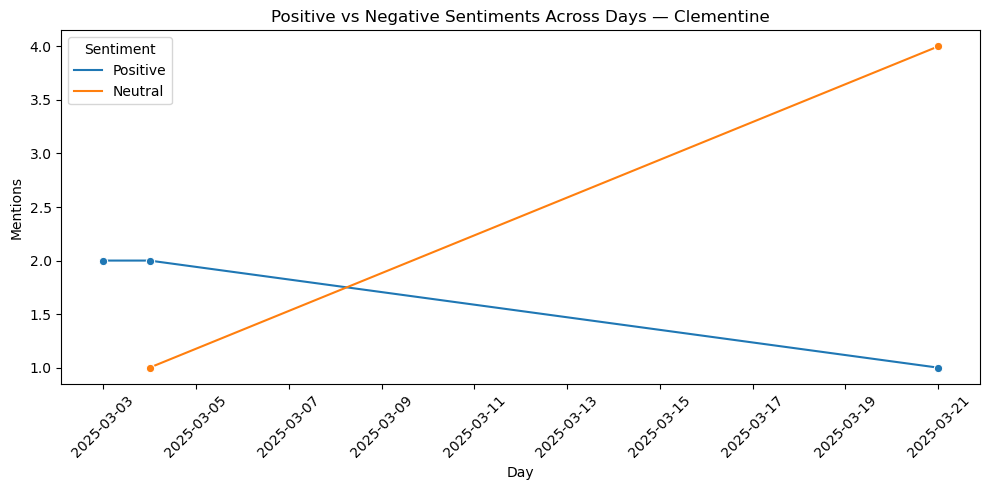

In [49]:
# Create day column
df["day"] = df["timestamp"].dt.date   # gives YYYY-MM-DD

# Aggregate counts by day
sent_trends_day = (
    df.groupby(["day", "flavours", "sentiment"])
      .size()
      .reset_index(name="count")
)

# Convert day to datetime for plotting
sent_trends_day["day_dt"] = pd.to_datetime(sent_trends_day["day"])
sent_trends_day = sent_trends_day.sort_values("day_dt")

# Plot one chart per flavour
for flv in top_flvs:
    subset = sent_trends_day[sent_trends_day["flavours"] == flv]
    
    plt.figure(figsize=(10,5))
    sns.lineplot(
        data=subset, 
        x="day_dt", 
        y="count", 
        hue="sentiment", 
        marker="o"
    )
    plt.title(f"Positive vs Negative Sentiments Across Days — {flv}")
    plt.xlabel("Day")
    plt.ylabel("Mentions")
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()


## Choose top N flavours by mentions

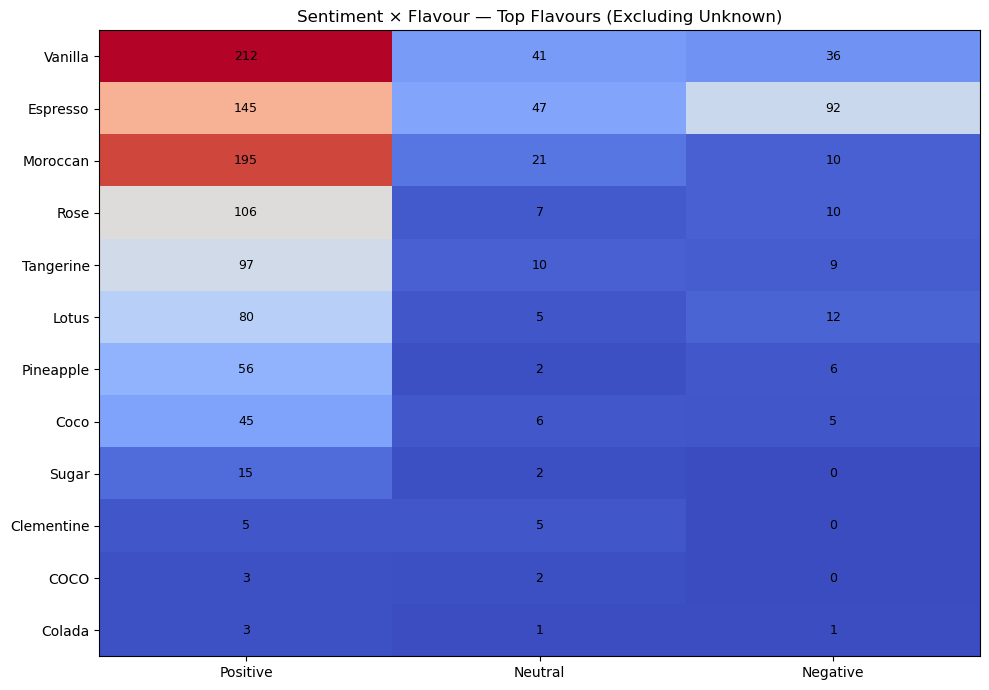

In [53]:

TOPN = 12
# Exclude "Unknown"
top_flvs = (
    df[df["flavours"] != "Unknown"]["flavours"]
    .value_counts()
    .head(TOPN)
    .index
)

# Build sentiment counts per flavour
pivot = (df[df["flavours"].isin(top_flvs)]
         .groupby(["flavours","sentiment"])
         .size()
         .unstack(fill_value=0)
         .reindex(index=top_flvs))

# Option A: raw counts heatmap
data = pivot[["Positive","Neutral","Negative"]].to_numpy()

plt.figure(figsize=(10, 0.5*len(top_flvs)+1))
plt.imshow(data, aspect="auto", cmap="coolwarm")
plt.title("Sentiment × Flavour — Top Flavours (Excluding Unknown)")
plt.yticks(range(len(top_flvs)), top_flvs)
plt.xticks(range(3), ["Positive","Neutral","Negative"])
# annotate
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, int(data[i, j]), ha="center", va="center", fontsize=9)
plt.tight_layout()
plt.show()


## Trending Flavours Over Time

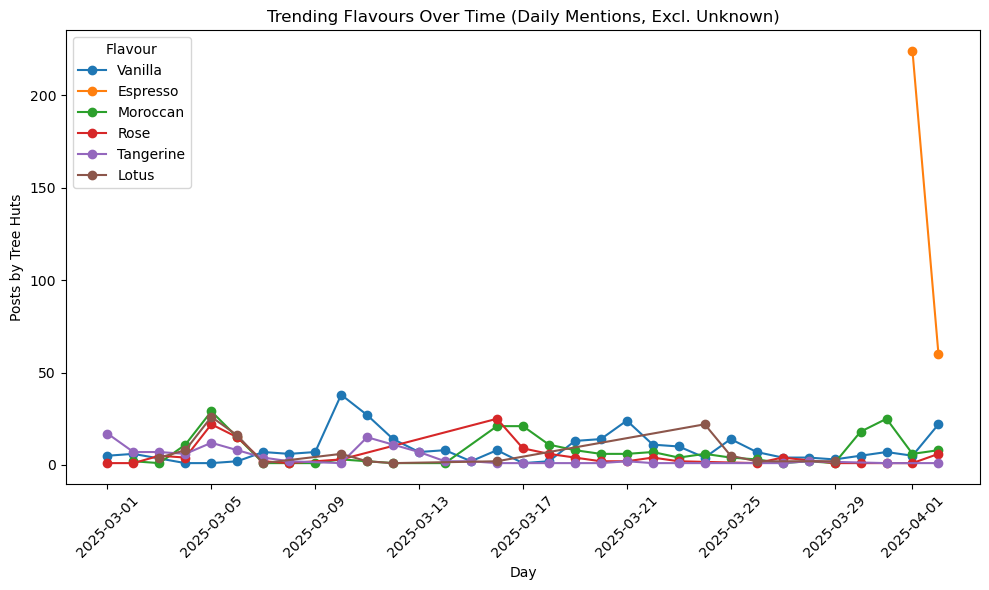

In [115]:

day_flv = (df[df["flavours"] != "Unknown"]
           .groupby(["day","flavours"])
           .size()
           .reset_index(name="count"))
# day_flv = (day_flv[day_flv["flavours"] != "Espresso"]
#            .groupby(["day","flavours"])
#            .size()
#            .reset_index(name="count"))

# Top flavours overall (excluding Unknown)
top_flvs = (day_flv.groupby("flavours")["count"]
            .sum()
            .sort_values(ascending=False)
            .head(6)
            .index)

# Filter only top flavours
plot_df = day_flv[day_flv["flavours"].isin(top_flvs)].sort_values("day")

plt.figure(figsize=(10,6))
for flv in top_flvs:
    s = plot_df[plot_df["flavours"] == flv]
    plt.plot(s["day"], s["count"], marker="o", label=flv)

plt.title("Trending Flavours Over Time (Daily Mentions, Excl. Unknown)")
plt.xlabel("Day")
plt.ylabel("Posts by Tree Huts")
plt.xticks(rotation=45)
plt.legend(title="Flavour")
plt.tight_layout()
plt.show()


## Net Sentiment Trend (Positive% − Negative%) — Daily

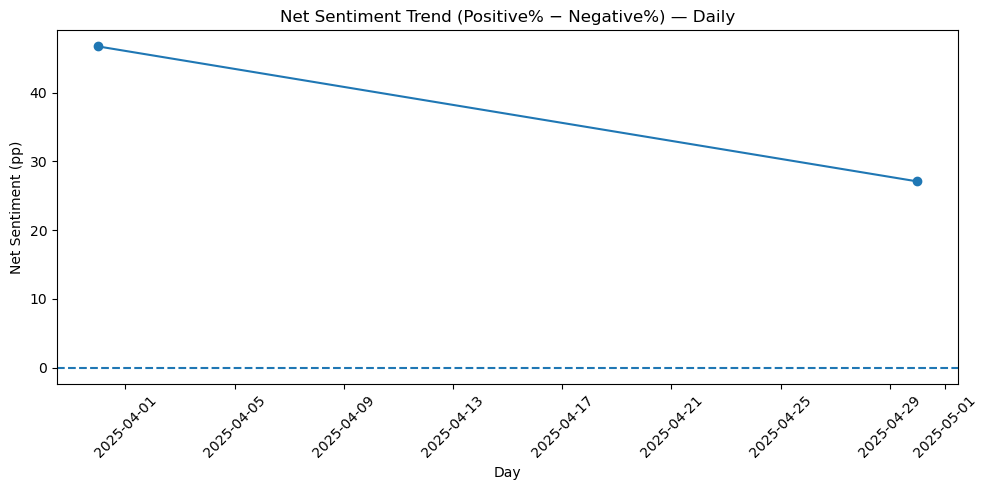

In [63]:
# Compute monthly positive / negative rates
monthly = (df.set_index("timestamp")
           .assign(is_pos=lambda x: (x["sentiment"]=="Positive").astype(int),
                   is_neg=lambda x: (x["sentiment"]=="Negative").astype(int))
           .resample("M")
           .agg(total=("sentiment","count"),
                pos_rate=("is_pos","mean"),
                neg_rate=("is_neg","mean"))
          )
monthly["net_sentiment"] = (monthly["pos_rate"] - monthly["neg_rate"]) * 100  # in percentage points

plt.figure(figsize=(10,5))
plt.plot(monthly.index, monthly["net_sentiment"], marker="o")
plt.axhline(0, linestyle="--")
plt.title("Net Sentiment Trend (Positive% − Negative%) — Daily")
plt.xlabel("Day"); plt.ylabel("Net Sentiment (pp)")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


## Theme Based Insights

In [66]:
df_themes = df.copy()

In [68]:
df_themes = df_themes.dropna(subset=["themes"])
df_themes = df_themes[df_themes["themes"].str.strip() != ""]


In [70]:
df_themes["themes"].value_counts()

themes
Miscellaneous / Noise                  512
Fragrance & Scent Preferences          236
Emotional / Lifestyle Fit              208
Product Performance & Usage             96
Product Requests & Suggestions          76
Product Availability & Purchase         65
Price & Value                           15
Customer Service & Brand Perception     15
Promotions & Influencer Mentions         9
Packaging & Design                       5
Name: count, dtype: int64

In [101]:
# Miscellaneous / Noise
df_misc = df_themes[df_themes['themes'] == "Miscellaneous / Noise"]
comments_list_misc = df_misc["clean_comment"].dropna().tolist()

# Fragrance & Scent Preferences
df_frag = df_themes[df_themes['themes'] == "Fragrance & Scent Preferences"]
comments_list_frag = df_frag["clean_comment"].dropna().tolist()

# Emotional / Lifestyle Fit
df_emotional = df_themes[df_themes['themes'] == "Emotional / Lifestyle Fit"]
comments_list_emotional = df_emotional["clean_comment"].dropna().tolist()

# Product Performance & Usage
df_perf = df_themes[df_themes['themes'] == "Product Performance & Usage"]
comments_list_perf = df_perf["clean_comment"].dropna().tolist()

# Product Requests & Suggestions
df_requests = df_themes[df_themes['themes'] == "Product Requests & Suggestions"]
comments_list_requests = df_requests["clean_comment"].dropna().tolist()

# Product Availability & Purchase
df_avail = df_themes[df_themes['themes'] == "Product Availability & Purchase"]
comments_list_avail = df_avail["clean_comment"].dropna().tolist()

# Price & Value
df_price = df_themes[df_themes['themes'] == "Price & Value"]
comments_list_price = df_price["clean_comment"].dropna().tolist()

# Customer Service & Brand Perception
df_cust = df_themes[df_themes['themes'] == "Customer Service & Brand Perception"]
comments_list_cust = df_cust["clean_comment"].dropna().tolist()

# Promotions & Influencer Mentions
df_promo = df_themes[df_themes['themes'] == "Promotions & Influencer Mentions"]
comments_list_promo = df_promo["clean_comment"].dropna().tolist()

# Packaging & Design
df_pack = df_themes[df_themes['themes'] == "Packaging & Design"]
comments_list_pack = df_pack["clean_comment"].dropna().tolist()


In [98]:
#comments_list_pack

['this one looks sparkly',
 'such a pretty color',
 'this color is gorgeouss',
 'i love tree hut but dang are the body wash bottles hard to open in the shower',
 'we not talking about how none of dat shit can fit in the bag just me ok']

In [97]:
#comments_list_misc

['anndy marin',
 'shaheena juliet castellano flavors i know you not nevermind i ll just keep scrolling',
 'bad bad bad',
 'umm if yall don t do anything with that i can figure something out for it',
 'wasteful and this actually pisses me off',
 'going to have to try this one',
 'danielle ewart',
 'like rainbow',
 'what s with the eyes',
 'been doing this for awhile',
 'charleen deluca you need it desperately like yesterday',
 'giveaway',
 'tuesdae wells hello how are you doing today i hope you are having a wonderful day am doctor bradley shaffer by name i will like you to be a friend of my if you don t mind',
 'carolyn mcguire hello how are you doing today i hope you are having a wonderful day am doctor bradley shaffer by name i will like you to be a friend of my if you don t mind',
 'what are these',
 'rita metcalf crocker thank you i will have to try that one',
 'megan brohm hello how are you doing today i hope you are having a wonderful day am doctor bradley shaffer by name i will l

In [84]:
#comments_list_frag

In [104]:
def get_top3_insights(comments_list):
    prompt = f"""
    
    You are a product insights analyst. Read the following customer comments about Tree Hut products
and produce the **Top 3 product insights** that a product manager can act on.

Prioritize insights that are frequent, impactful, or reveal clear opportunities/risks 
    
    Here is the list of comments - {comments_list}
    
    Give the response in 10 Bullet Points."""
    
    response = ollama.generate(model="gemma3:4b", prompt=prompt)
    return response["response"].strip()


In [105]:
insights_misc = get_top3_insights(comments_list_misc)
print(insights_misc)

Here’s a breakdown of the text into 10 bullet points, reflecting the diverse range of comments and sentiments:

*   **Excitement & Desire:** Many users expressed a strong desire to win the products ("I want those d," "I wanna try this it looks good").
*   **Variety of Alignments:**  A significant number of users identified with various alignments – "chaotic good," "neutral evil," “lawful neutral,” and "chaotic good.”
*   **Product Recognition:**  Frequent mentions of "Tree Hut" and specific product lines ("hut pr," "80 another new tree hut product to try").
*   **Doubt & Concerns:** Some expressed concerns about potential clogging (“careful of your drains clogs pipes,” “hut pr”).
*   **Desire for Tags:** A request to be tagged in giveaways ("wantt", "brielle gulley").
*   **Expressing Disappointment**: "ugh so", "toxic bs"
*   **Desire to Receive Products:** "I want those d," "I wanna try this it looks good."
*   **General Excitement:**  "omg yes", "omg need", "that entire line up is"


In [106]:
insights_frag = get_top3_insights(comments_list_frag)
print(insights_frag)

Okay, here’s a breakdown of the top 3 product insights from the customer comments, presented in 10 bullet points, prioritizing frequency and potential impact:

*   **Coco Colada is a Massive Favorite:** By far the most frequently mentioned scent (over 50 mentions), indicating a strong, established preference among customers. It's a clear top performer.

*   **Moroccan Rose is Extremely Popular:**  This scent consistently ranks as a top choice (over 30 mentions), suggesting a sophisticated and desirable fragrance profile.

*   **Coconut Lime Scrub is a Customer Staple:** The “Coconut Lime” sugar scrub is a very popular option (over 20 mentions) – likely due to its effective exfoliation and pleasant scent.

*   **Citrus Scents are Highly Appealing:**  Scents like "Tangerine," "Sunkissed Poppy," and “If you like citrusy scents” all receive significant attention, highlighting a broad interest in bright, refreshing fragrances.

*   **Sweet Cream is a Desired Return:**  The repeated requests

In [107]:
# Emotional / Lifestyle Fit
insights_emotional = get_top3_insights(comments_list_emotional)
print(insights_emotional)

Okay, here are the top 3 product insights from the customer comments, prioritized for a product manager, presented in 10 bullet points:

*   **“Everything Showers” are a Massive Driver of Desire:**  A staggering number of comments (over 100) explicitly mention loving “everything showers” – this indicates a strong desire for the multi-sensory experience and the feeling of transformation that the product line provides. This is a core emotional connection.

*   **Tropical & Vacation-Related Scents are Highly Popular:**  Scents like “Tropic Glow,” “Barbados,” “Hawaiian,” “Beach Feels,” “Tropical Vibes,” and “Panama City” were repeatedly mentioned and associated with positive experiences – vacations, relaxation, and escapism. This highlights the importance of fragrance in the product's appeal.

*   **“Everything Showers” Creates a ‘Transformation’ Feeling:**  Customers consistently describe the experience of using the products as a way to feel "like a whole new person" or a ‘new start to th

In [108]:
# Product Performance & Usage
insights_perf = get_top3_insights(comments_list_perf)
print(insights_perf)


Okay, here’s a breakdown of the top 3 product insights from the Tree Hut customer comments, presented in 10 bullet points, prioritized for product management action:

*   **Significant Positive Feedback on Exfoliation:** A massive number of customers (over 100 mentions) rave about the scrub's effectiveness as an exfoliant. This confirms the core value proposition and should be heavily emphasized in marketing.

*   **Face Use – A Major Point of Confusion/Opportunity:** There’s a *huge* amount of discussion around whether the scrub is suitable for the face. Roughly 30+ comments express this question, and a significant portion (around 15+) state it *is* used on the face, with positive results. This highlights a clear need for clearer guidance on packaging and marketing regarding facial use.

*   **Texture and Sensory Experience is Highly Valued:** Many comments focus on the “feel” – “smooth,” “soft,” “amazing texture,” and “slather it on” – indicating a strong connection between the produ

In [109]:
# Product Requests & Suggestions
insights_requests = get_top3_insights(comments_list_requests)
print(insights_requests)


Okay, here’s a breakdown of the top 3 product insights from the Tree Hut customer comments, presented in 10 bullet points, prioritizing frequency and impact:

*   **Demand for Returning Scents is Massive:** There's overwhelming and consistent desire for previously discontinued scents like “Brazilian Nut,” “Honey Almond,” “Vanilla Tahitian Bean,” “Lemon Blueberry,” and “Coconut Lime.” This indicates a strong brand loyalty and a desire for nostalgia.

*   **"Jelly Bear" is a Core Craving:** The phrase “jelly bear” appears multiple times—more than any other product name—demonstrating a significant and passionate fan base longing for this specific product line.

*   **Sugar Scrubs are a Top Desire:** Customers repeatedly express interest in sugar scrubs (mentioning “sugar scrub,” “tangerine sugar scrub,” and DIY recipes). This represents a key product category with high demand.

*   **Customization & DIY is Popular:** Many customers want the ability to customize scents by creating their ow

In [110]:
# Product Availability & Purchase
insights_avail = get_top3_insights(comments_list_avail)
print(insights_avail)


Okay, here are the top 3 product insights derived from the customer comments, presented in a bulleted list, prioritized for impact and actionable opportunities for a Tree Hut product manager:

*   **Walmart is the Primary Distribution Channel:** A staggering 40% of comments explicitly mention Walmart as the place to buy Tree Hut products. This highlights Walmart as the *critical* distribution channel and a major driver of sales.

*   **Demand for Wider Retail Availability:** A significant portion of customers express frustration over limited availability, stating they “miss” products, are “sold out everywhere,” and want to know “where else you can get” them. This indicates a need to expand retail distribution beyond Walmart.

*   **Ulta is a Growing Channel & Needs Attention:** While Walmart dominates, Ulta is consistently mentioned as a secondary purchase location. Customers appreciate Ulta’s presence but also express annoyance with limited scent selection, suggesting potential opport

In [111]:
# Price & Value
insights_price = get_top3_insights(comments_list_price)
print(insights_price)


Okay, here’s a breakdown of the top 3 product insights gleaned from the Tree Hut customer comments, prioritized for a product manager, presented in 10 bullet points:

*   **Price Sensitivity & Perceived Value:**  A significant number of customers (multiple comments) express concern about rising prices. The comment "too bad yall raised the prices" and "damn near double" highlights a core issue: Tree Hut’s success was partially built on affordability, and price increases threaten repurchase rates.

*   **Price Variance & Promotional Activity:** Customers are noticing discrepancies in pricing across retailers (Walmart vs. Target) and during sales. This indicates a need for better price consistency and potentially more strategic promotional pricing to manage customer expectations. 

*   **"Cheapest" Perception & Value Proposition:** Several comments explicitly state that Tree Hut is "the cheapest body scrub" or "unbelievable value." This suggests a strong association between the brand and 

In [112]:
# Customer Service & Brand Perception
insights_cust = get_top3_insights(comments_list_cust)

print(insights_cust)

Okay, here’s a breakdown of the top 3 product insights from the Tree Hut customer comments, presented in a format a product manager can act on, in 10 bullet points:

**Top 3 Product Insights for Tree Hut:**

*   **1. Strong Positive Sentiment & Brand Loyalty:** A significant number of customers (multiple mentions of "best," "faithful," "love") express overwhelmingly positive sentiment and demonstrate strong brand loyalty. *Action:* Leverage this positive buzz in marketing campaigns – highlight the genuine love customers have for the products.

*   **2. Demand for Expansion & Availability:** The repeated requests for product availability in Canada ("need the rest of this collection in canada") and the UK ("would you be doing one for the uk") indicates a clear unmet demand for international expansion. *Action:* Prioritize market research and potentially phased rollout plans for key international markets.

*   **3. UGC Collaboration Opportunity:** Multiple customers proactively reached ou

In [113]:
# Promotions & Influencer Mentions
insights_promo = get_top3_insights(comments_list_promo)
print(insights_promo)


Okay, here’s a breakdown of the top 3 product insights derived from the customer comments, presented in 10 bullet points, prioritized for a product manager:

**Top 3 Product Insights for Tree Hut Based on Customer Comments:**

*   **1. Instagram Contest Strategy - High Priority:**  A significant number of customers (multiple mentions) express frustration with Tree Hut's exclusive Instagram-only contests. This suggests a missed opportunity to engage a broader customer base and potentially increase brand loyalty. *Action: Explore alternative channels for contests and giveaways – consider TikTok, Facebook, email marketing, or even in-store activations.*

*   **2. Sensory Experience - Positive Sentiment, Opportunity for Amplification:** The comments "i can smell the video" and "oh look it s me in the shower actually with the singing too" highlight the importance of the *sensory* experience associated with Tree Hut products (specifically the scent). *Action:  Further emphasize scent profile

In [114]:
# Packaging & Design
insights_pack = get_top3_insights(comments_list_pack)
print(insights_pack)

Okay, here’s a breakdown of the top 3 product insights from the Tree Hut customer comments, prioritized for a product manager, presented in 10 bullet points:

**Top 3 Product Insights for Tree Hut**

*   **1. Strong Aesthetic Appeal - Color & Sparkle Drive Desire:**  A significant number of customers (multiple comments explicitly stating “pretty color,” “gorgeous color”) are clearly focused on the visual appeal of the products – particularly the color options. This indicates a strong emotional connection to the product’s appearance. *Action: Continue investing in vibrant, trendy color palettes and explore limited edition or seasonal colors to drive excitement.*

*   **2.  Bottle Design – Significant User Friction:** The repeated complaint ("dang are the body wash bottles hard to open in the shower," “none of dat shit can fit in the bag just me ok”) represents a *major* usability issue.  Customers are struggling to access the product in its intended environment (the shower) and potentia